In [28]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
from sklearn.metrics import f1_score,classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# necessario mettere le immagini in content altrimenti è troppo lento,
!cp -r /content/drive/MyDrive/Colab_Notebooks/data/train /content/
!cp -r /content/drive/MyDrive/Colab_Notebooks/data/valid /content/
!cp -r /content/drive/MyDrive/Colab_Notebooks/data/test /content

In [4]:
# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("gpu presente")

gpu presente


## Preprocessing

In [5]:
# Dataset senza trasformazioni di normalizzazione
dataset = datasets.ImageFolder('train', transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# Calcolo della media e della deviazione standard
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

for data in loader:
    data = data[0]  # Ottieni solo le immagini
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)  # Reshape per calcolare la media e la std per canale
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# Converti mean e std a liste di Python
mean = mean.tolist()
std = std.tolist()

print(f'Media: {mean}')
print(f'Deviazione standard: {std}')

batch_size = 32
num_workers = 2

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Media: [0.41874998807907104, 0.4286283254623413, 0.3027363717556]
Deviazione standard: [0.23694270849227905, 0.21736641228199005, 0.22630877792835236]


In [6]:
# Inizialmente non facciamo data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Adatta la dimensione
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),  # Adatta la dimensione
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  # Adatta la dimensione
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


# Crea i dataset
image_datasets = {
    'train': datasets.ImageFolder("train", transform=data_transforms['train']),
    'validation': datasets.ImageFolder("valid", transform=data_transforms['validation']),
    'test': datasets.ImageFolder("test", transform=data_transforms['test']),
}

# Crea i dataloader
batch_size = 32
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers),
}

In [7]:
print(f"il dataset di allenamento ha {str(len(image_datasets['train']))} immagini, equidivise per classe")
print(f"il dataset di validazione ha {str(len(image_datasets['validation']))} immagini, equidivise per classe")
print(f"il dataset di test ha {str(len(image_datasets['test']))} immagini, equidivise per classe")

il dataset di allenamento ha 1275 immagini, equidivise per classe
il dataset di validazione ha 364 immagini, equidivise per classe
il dataset di test ha 182 immagini, equidivise per classe


## Visualizzazione di  alcune immagini casuali per classe

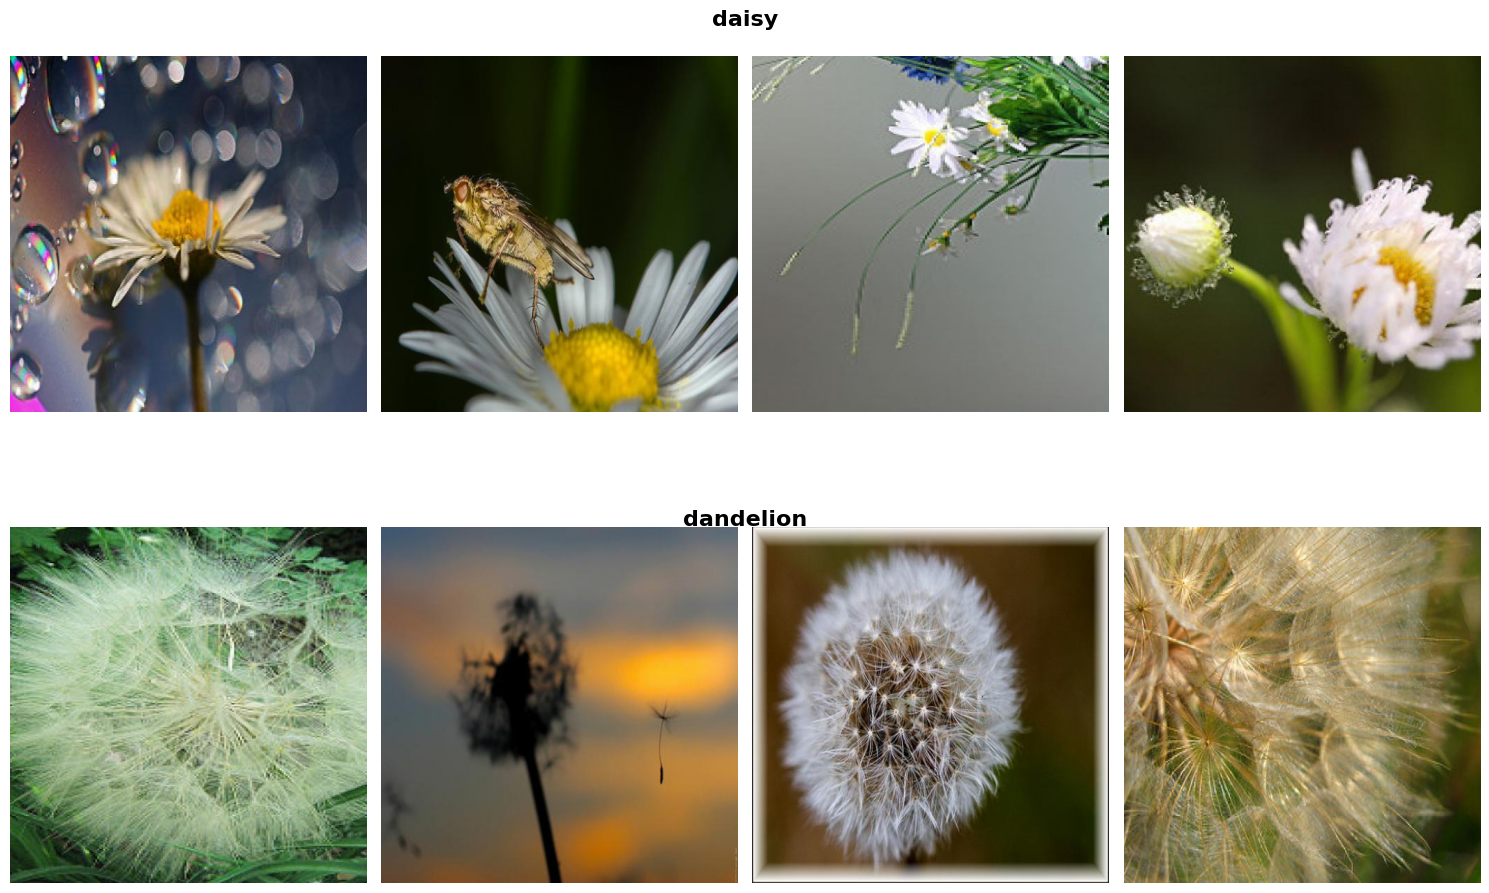

In [8]:
main_folder = '/content/drive/MyDrive/Colab_Notebooks/data/train'

# Ottieni i nomi delle sottocartelle (classi)
classes = [d for d in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, d))]

# Imposta il numero di immagini casuali da mostrare per ciascuna classe
num_images = 4

# Crea una figura per mostrare le immagini
fig, axs = plt.subplots(nrows=len(classes), ncols=num_images, figsize=(15, 5 * len(classes)))

# Itera su ciascuna classe
for i, class_name in enumerate(classes):
    class_folder = os.path.join(main_folder, class_name)
    images = os.listdir(class_folder)

    # Seleziona immagini casuali
    selected_images = random.sample(images, num_images)

    # Mostra le immagini
    for j, image_name in enumerate(selected_images):
        image_path = os.path.join(class_folder, image_name)
        img = mpimg.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

    # Aggiungi il nome della classe sopra le immagini, centrato
    fig.text(0.5, 1 - (i / len(classes)) - 0.05, class_name, ha='center',
             va='center', fontsize=16, fontweight='bold')

# Aggiusta lo spazio tra le righe per evitare sovrapposizioni tra titoli e immagini
plt.subplots_adjust(hspace=0.6)
plt.tight_layout()
plt.show()

## Addestramento modelli con transfer learning e fine tuning

#### Si scelgono 3 modelli adatti per il nostro task e li addestriamo sui nostri dati utilizzando la tecnica del transfer learning e la tecnica del fine tuning

In [9]:
def get_classifier_and_params(model):
    # Prova i nomi più comuni usati nei modelli TIMM
    candidate_attrs = ['fc', 'classifier', 'head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            classifier = getattr(model, attr)
            return attr, classifier, classifier.parameters()

    # Se nessuno è trovato, prova a cercare dinamicamente un layer Linear finale
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, torch.nn.Linear):
            return name, module, module.parameters()

    raise ValueError("Non è stato trovato un classificatore finale gestibile nel modello.")

In [10]:
# funzione per fare transfer learning, addestrando soltanto gli ultimi strati densi
def train_last_layers(model, train_loader, validation_loader, model_name, num_epochs=10, patience=3, learning_rate=0.001):
    # Congela tutti i layer
    for param in model.parameters():
        param.requires_grad = False

    # Trova il classificatore dinamicamente
    classifier_attr, classifier_module, _ = get_classifier_and_params(model)

    # Sblocca i suoi parametri
    for param in classifier_module.parameters():
        param.requires_grad = True

    # FILTRA i parametri che hanno requires_grad = True
    trainable_params = [p for p in model.parameters() if p.requires_grad]

    if not trainable_params:
        raise ValueError("Nessun parametro sbloccato per l’addestramento. Controlla il classificatore.")

    optimizer = Adam(trainable_params, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    best_f1_macro = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        # Validazione
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calcola lo score F1 macro
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        print(f'Validation F1 Macro: {f1_macro}')

        # Early stopping
        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            patience_counter = 0
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab_Notebooks/models/{model_name}_tl.pth")
            print("new best f1 macro! model saved!")
            print(f"BEST F1: {str(round(best_f1_macro, 4))}")
        else:
            patience_counter += 1
            print(f"BEST F1: {str(round(best_f1_macro, 4))}")

        if patience_counter >= patience:
            print("Early stopping activated.")
            break

    print("Training completed.")
    return best_f1_macro

In [11]:
# funzione per fare fine tuning, ripartendo dai pesi del modello e adattandoli al nostro task
def fine_tune_model(model, train_loader, validation_loader, model_name, num_epochs=10, patience=3, learning_rate=0.001):
    # Sblocca tutti i layer
    for param in model.parameters():
        param.requires_grad = True

    # Trova il classificatore per log e salvataggio intelligente
    try:
        classifier_attr, classifier_module, _ = get_classifier_and_params(model)
    except ValueError:
        classifier_attr = "unknown"
        print("Classificatore non trovato dinamicamente, ma proseguo con fine-tuning completo.")

    # Filtra solo i parametri che vanno effettivamente ottimizzati
    trainable_params = [p for p in model.parameters() if p.requires_grad]

    if not trainable_params:
        raise ValueError("Nessun parametro con requires_grad=True trovato. Controlla il modello.")

    optimizer = Adam(trainable_params, lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    best_f1_macro = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        # Validazione
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calcola F1 macro
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        print(f'Validation F1 Macro: {f1_macro}')

        # Early stopping
        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            patience_counter = 0
            torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab_Notebooks/models/{model_name}_ft.pth")
            print("New best F1 macro! Model saved!")
            print(f"BEST F1: {str(round(best_f1_macro, 4))}")
        else:
            patience_counter += 1
            print(f"BEST F1: {str(round(best_f1_macro, 4))}")

        if patience_counter >= patience:
            print("Early stopping activated.")
            break

    print("Fine-tuning completed.")
    return best_f1_macro

In [12]:
# funzione che adatta tutti i modelli che utilizziamo ad un task binario
def adapt_model_for_binary_classification(model_name, num_classes=2, pretrained=True):
    model = timm.create_model(model_name, pretrained=pretrained)

    if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Linear):
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

    elif hasattr(model, 'fc') and isinstance(model.fc, nn.Linear):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

    elif hasattr(model, 'head') and isinstance(model.head, nn.Linear):
        in_features = model.head.in_features
        model.head = nn.Linear(in_features, num_classes)

    else:
        # Fallback: trova l'ultimo Linear module
        for name, module in reversed(list(model.named_modules())):
            if isinstance(module, nn.Linear):
                in_features = module.in_features
                parent_module = dict(model.named_modules())[name.rsplit('.', 1)[0]] if '.' in name else model
                setattr(parent_module, name.rsplit('.', 1)[-1], nn.Linear(in_features, num_classes))
                break
        else:
            raise ValueError("Il modello non ha un classificatore finale modificabile.")

    return model.to(device)


In [13]:
# salvo le performance dei modelli in un dizionario
best_models_f1 = dict()

num_epochs = 100
patience = 10

In [14]:
# Adatta il modello ResNet50
model_resnet50 = adapt_model_for_binary_classification('resnet50')

# Addestra solo gli ultimi strati
best_models_f1["resnet50_tl"] = train_last_layers(model_resnet50, dataloaders["train"], dataloaders["validation"], 'resnet50', num_epochs=num_epochs, patience=patience)

# Fine-tuning completo
best_models_f1["resnet50_ft"] = fine_tune_model(model_resnet50, dataloaders["train"], dataloaders["validation"], 'resnet50', num_epochs=num_epochs, patience=patience)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch 1/100: 100%|██████████| 40/40 [00:07<00:00,  5.57it/s]

Epoch 1, Loss: 0.5595404632389546


Validation F1 Macro: 0.9193058899973244
new best f1 macro! model saved!
BEST F1: 0.9193


Epoch 2/100: 100%|██████████| 40/40 [00:06<00:00,  6.54it/s]

Epoch 2, Loss: 0.4041529789566994


Validation F1 Macro: 0.9164703362604412
BEST F1: 0.9193


Epoch 3/100: 100%|██████████| 40/40 [00:06<00:00,  5.87it/s]

Epoch 3, Loss: 0.3329440295696259


Validation F1 Macro: 0.9306016304803739
new best f1 macro! model saved!
BEST F1: 0.9306


Epoch 4/100: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

Epoch 4, Loss: 0.29091280326247215


Validation F1 Macro: 0.9253503474991455
BEST F1: 0.9306


Epoch 5/100: 100%|██████████| 40/40 [00:06<00:00,  5.83it/s]

Epoch 5, Loss: 0.2597536340355873


Validation F1 Macro: 0.9362235375673225
new best f1 macro! model saved!
BEST F1: 0.9362


Epoch 6/100: 100%|██████████| 40/40 [00:06<00:00,  6.39it/s]

Epoch 6, Loss: 0.2415758490562439


Validation F1 Macro: 0.9414122678602908
new best f1 macro! model saved!
BEST F1: 0.9414


Epoch 7/100: 100%|██████████| 40/40 [00:08<00:00,  4.88it/s]

Epoch 7, Loss: 0.22009376883506776


Validation F1 Macro: 0.933339437780423
BEST F1: 0.9414


Epoch 8/100: 100%|██████████| 40/40 [00:06<00:00,  5.98it/s]

Epoch 8, Loss: 0.2138100465759635


Validation F1 Macro: 0.944383327221611
new best f1 macro! model saved!
BEST F1: 0.9444


Epoch 9/100: 100%|██████████| 40/40 [00:06<00:00,  6.32it/s]

Epoch 9, Loss: 0.20685387812554837


Validation F1 Macro: 0.9388944846320544
BEST F1: 0.9444


Epoch 10/100: 100%|██████████| 40/40 [00:08<00:00,  4.50it/s]

Epoch 10, Loss: 0.19182245321571828


Validation F1 Macro: 0.9361535000419441
BEST F1: 0.9444


Epoch 11/100: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

Epoch 11, Loss: 0.17512207962572574


Validation F1 Macro: 0.9416377171215881
BEST F1: 0.9444


Epoch 12/100: 100%|██████████| 40/40 [00:06<00:00,  6.37it/s]

Epoch 12, Loss: 0.16854265481233596


Validation F1 Macro: 0.9498161764705882
new best f1 macro! model saved!
BEST F1: 0.9498


Epoch 13/100: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s]

Epoch 13, Loss: 0.1706890484318137


Validation F1 Macro: 0.944383327221611
BEST F1: 0.9498


Epoch 14/100: 100%|██████████| 40/40 [00:08<00:00,  4.96it/s]

Epoch 14, Loss: 0.16271337922662496


Validation F1 Macro: 0.9388944846320544
BEST F1: 0.9498


Epoch 15/100: 100%|██████████| 40/40 [00:06<00:00,  6.50it/s]

Epoch 15, Loss: 0.1566678136587143


Validation F1 Macro: 0.9499449944994499
new best f1 macro! model saved!
BEST F1: 0.9499


Epoch 16/100: 100%|██████████| 40/40 [00:07<00:00,  5.11it/s]

Epoch 16, Loss: 0.15549523420631886


Validation F1 Macro: 0.9471314451706608
BEST F1: 0.9499


Epoch 17/100: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]

Epoch 17, Loss: 0.15193891543895005


Validation F1 Macro: 0.9498822017562647
BEST F1: 0.9499


Epoch 18/100: 100%|██████████| 40/40 [00:07<00:00,  5.51it/s]

Epoch 18, Loss: 0.14925619754940272


Validation F1 Macro: 0.9471314451706608
BEST F1: 0.9499


Epoch 19/100: 100%|██████████| 40/40 [00:06<00:00,  5.89it/s]

Epoch 19, Loss: 0.14055294692516326


Validation F1 Macro: 0.944383327221611
BEST F1: 0.9499


Epoch 20/100: 100%|██████████| 40/40 [00:08<00:00,  4.99it/s]

Epoch 20, Loss: 0.1373071398586035


Validation F1 Macro: 0.944383327221611
BEST F1: 0.9499


Epoch 21/100: 100%|██████████| 40/40 [00:06<00:00,  6.51it/s]

Epoch 21, Loss: 0.13259178893640639


Validation F1 Macro: 0.9471960297766749
BEST F1: 0.9499


Epoch 22/100: 100%|██████████| 40/40 [00:06<00:00,  5.88it/s]

Epoch 22, Loss: 0.13587494269013406


Validation F1 Macro: 0.9471960297766749
BEST F1: 0.9499


Epoch 23/100: 100%|██████████| 40/40 [00:07<00:00,  5.22it/s]

Epoch 23, Loss: 0.13088483894243835


Validation F1 Macro: 0.9444495314836858
BEST F1: 0.9499


Epoch 24/100: 100%|██████████| 40/40 [00:06<00:00,  6.33it/s]

Epoch 24, Loss: 0.12378957811743022


Validation F1 Macro: 0.9444495314836858
BEST F1: 0.9499


Epoch 25/100: 100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

Epoch 25, Loss: 0.1187000909820199


Validation F1 Macro: 0.9471960297766749
BEST F1: 0.9499
Early stopping activated.
Training completed.


Epoch 1/100: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

Epoch 1, Loss: 0.13928784443996847


Validation F1 Macro: 0.9556097560975609
New best F1 macro! Model saved!
BEST F1: 0.9556


Epoch 2/100: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]

Epoch 2, Loss: 0.05577763401670381


Validation F1 Macro: 0.9414122678602908
BEST F1: 0.9556


Epoch 3/100: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]

Epoch 3, Loss: 0.02095463405130431


Validation F1 Macro: 0.955818540433925
New best F1 macro! Model saved!
BEST F1: 0.9558


Epoch 4/100: 100%|██████████| 40/40 [00:13<00:00,  2.89it/s]

Epoch 4, Loss: 0.007115815122233471


Validation F1 Macro: 0.9612388949738347
New best F1 macro! Model saved!
BEST F1: 0.9612


Epoch 5/100: 100%|██████████| 40/40 [00:13<00:00,  2.93it/s]

Epoch 5, Loss: 0.0055312859622063115


Validation F1 Macro: 0.9557015942558111
BEST F1: 0.9612


Epoch 6/100: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

Epoch 6, Loss: 0.0040535680771427


Validation F1 Macro: 0.9612388949738347
BEST F1: 0.9612


Epoch 7/100: 100%|██████████| 40/40 [00:13<00:00,  2.96it/s]

Epoch 7, Loss: 0.0009970662233172334


Validation F1 Macro: 0.9639897417945771
New best F1 macro! Model saved!
BEST F1: 0.964


Epoch 8/100: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

Epoch 8, Loss: 0.0006580573683095281


Validation F1 Macro: 0.9667761956918584
New best F1 macro! Model saved!
BEST F1: 0.9668


Epoch 9/100: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]

Epoch 9, Loss: 0.0005885170421606745


Validation F1 Macro: 0.9639897417945771
BEST F1: 0.9668


Epoch 10/100: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]

Epoch 10, Loss: 0.00024011708228499629


Validation F1 Macro: 0.9639897417945771
BEST F1: 0.9668


Epoch 11/100: 100%|██████████| 40/40 [00:13<00:00,  2.99it/s]

Epoch 11, Loss: 0.0002666491668605886


Validation F1 Macro: 0.9639897417945771
BEST F1: 0.9668


Epoch 12/100: 100%|██████████| 40/40 [00:14<00:00,  2.83it/s]

Epoch 12, Loss: 0.00029620723153129803


Validation F1 Macro: 0.9612388949738347
BEST F1: 0.9668


Epoch 13/100: 100%|██████████| 40/40 [00:16<00:00,  2.37it/s]

Epoch 13, Loss: 0.00034081555588727497


Validation F1 Macro: 0.9640247842779488
BEST F1: 0.9668


Epoch 14/100: 100%|██████████| 40/40 [00:15<00:00,  2.55it/s]

Epoch 14, Loss: 0.015479804439718237


Validation F1 Macro: 0.8943313326272018
BEST F1: 0.9668


Epoch 15/100: 100%|██████████| 40/40 [00:15<00:00,  2.56it/s]


Epoch 15, Loss: 0.056953747634543105
Validation F1 Macro: 0.93074950345111
BEST F1: 0.9668


Epoch 16/100: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]

Epoch 16, Loss: 0.06141725133638829


Validation F1 Macro: 0.9501142074006396
BEST F1: 0.9668


Epoch 17/100: 100%|██████████| 40/40 [00:14<00:00,  2.80it/s]

Epoch 17, Loss: 0.022492375114234166


Validation F1 Macro: 0.9527543424317618
BEST F1: 0.9668


Epoch 18/100: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]

Epoch 18, Loss: 0.005897189030110894


Validation F1 Macro: 0.950060975609756
BEST F1: 0.9668
Early stopping activated.
Fine-tuning completed.


In [15]:
# Adatta il modello EfficientNet-B0
model_efficientnet_b0 = adapt_model_for_binary_classification('efficientnet_b0')

# Addestra solo gli ultimi strati
best_models_f1["efficientnet_b0_tl"] = train_last_layers(model_efficientnet_b0, dataloaders["train"], dataloaders["validation"], 'efficientnet_b0', num_epochs=num_epochs, patience=patience)

# Fine-tuning completo
best_models_f1["efficientnet_b0_ft"] = fine_tune_model(model_efficientnet_b0, dataloaders["train"], dataloaders["validation"], 'efficientnet_b0', num_epochs=num_epochs, patience=patience)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/100: 100%|██████████| 40/40 [00:07<00:00,  5.48it/s]

Epoch 1, Loss: 0.4202294934540987


Validation F1 Macro: 0.9196694240032874
new best f1 macro! model saved!
BEST F1: 0.9197


Epoch 2/100: 100%|██████████| 40/40 [00:07<00:00,  5.70it/s]

Epoch 2, Loss: 0.25015182644128797


Validation F1 Macro: 0.9224777899476695
new best f1 macro! model saved!
BEST F1: 0.9225


Epoch 3/100: 100%|██████████| 40/40 [00:05<00:00,  7.11it/s]

Epoch 3, Loss: 0.19798926506191492


Validation F1 Macro: 0.9225508374114715
new best f1 macro! model saved!
BEST F1: 0.9226


Epoch 4/100: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s]

Epoch 4, Loss: 0.19866134263575078


Validation F1 Macro: 0.9330882352941177
new best f1 macro! model saved!
BEST F1: 0.9331


Epoch 5/100: 100%|██████████| 40/40 [00:05<00:00,  7.12it/s]

Epoch 5, Loss: 0.16755131985992194


Validation F1 Macro: 0.9252094637271987
BEST F1: 0.9331


Epoch 6/100: 100%|██████████| 40/40 [00:06<00:00,  6.32it/s]


Epoch 6, Loss: 0.16189317647367715
Validation F1 Macro: 0.9251319788833786
BEST F1: 0.9331


Epoch 7/100: 100%|██████████| 40/40 [00:07<00:00,  5.61it/s]

Epoch 7, Loss: 0.13510258840397


Validation F1 Macro: 0.9278658536585367
BEST F1: 0.9331


Epoch 8/100: 100%|██████████| 40/40 [00:05<00:00,  7.03it/s]

Epoch 8, Loss: 0.13231678633019328


Validation F1 Macro: 0.927607624759049
BEST F1: 0.9331


Epoch 9/100: 100%|██████████| 40/40 [00:07<00:00,  5.56it/s]

Epoch 9, Loss: 0.13761561457067728


Validation F1 Macro: 0.9330882352941177
BEST F1: 0.9331


Epoch 10/100: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]


Epoch 10, Loss: 0.12311285343021154
Validation F1 Macro: 0.9276983253880944
BEST F1: 0.9331


Epoch 11/100: 100%|██████████| 40/40 [00:06<00:00,  6.47it/s]

Epoch 11, Loss: 0.1258471471257508


Validation F1 Macro: 0.9332599926659333
new best f1 macro! model saved!
BEST F1: 0.9333


Epoch 12/100: 100%|██████████| 40/40 [00:06<00:00,  5.85it/s]

Epoch 12, Loss: 0.12800247482955457


Validation F1 Macro: 0.9332599926659333
BEST F1: 0.9333


Epoch 13/100: 100%|██████████| 40/40 [00:05<00:00,  6.96it/s]

Epoch 13, Loss: 0.11465536570176482


Validation F1 Macro: 0.9194978913572338
BEST F1: 0.9333


Epoch 14/100: 100%|██████████| 40/40 [00:07<00:00,  5.55it/s]

Epoch 14, Loss: 0.11252503516152501


Validation F1 Macro: 0.9330882352941177
BEST F1: 0.9333


Epoch 15/100: 100%|██████████| 40/40 [00:05<00:00,  6.90it/s]

Epoch 15, Loss: 0.10504209836944937


Validation F1 Macro: 0.930436112066659
BEST F1: 0.9333


Epoch 16/100: 100%|██████████| 40/40 [00:06<00:00,  6.38it/s]

Epoch 16, Loss: 0.10404746988788247


Validation F1 Macro: 0.9248710010319918
BEST F1: 0.9333


Epoch 17/100: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]

Epoch 17, Loss: 0.08852588161826133


Validation F1 Macro: 0.9167682926829268
BEST F1: 0.9333


Epoch 18/100: 100%|██████████| 40/40 [00:05<00:00,  7.06it/s]

Epoch 18, Loss: 0.09516745628789067


Validation F1 Macro: 0.9222293440771603
BEST F1: 0.9333


Epoch 19/100: 100%|██████████| 40/40 [00:08<00:00,  4.75it/s]

Epoch 19, Loss: 0.09669125946238637


Validation F1 Macro: 0.930436112066659
BEST F1: 0.9333


Epoch 20/100: 100%|██████████| 40/40 [00:05<00:00,  6.94it/s]

Epoch 20, Loss: 0.10344164306297898


Validation F1 Macro: 0.9225508374114715
BEST F1: 0.9333


Epoch 21/100: 100%|██████████| 40/40 [00:05<00:00,  7.08it/s]

Epoch 21, Loss: 0.08743620244786143


Validation F1 Macro: 0.9170187543694337
BEST F1: 0.9333
Early stopping activated.
Training completed.


Epoch 1/100: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s]

Epoch 1, Loss: 0.23485437072813511


Validation F1 Macro: 0.9360012231013263
New best F1 macro! Model saved!
BEST F1: 0.936


Epoch 2/100: 100%|██████████| 40/40 [00:08<00:00,  4.56it/s]

Epoch 2, Loss: 0.10864707143045962


Validation F1 Macro: 0.9638709677419355
New best F1 macro! Model saved!
BEST F1: 0.9639


Epoch 3/100: 100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

Epoch 3, Loss: 0.04957884090254083


Validation F1 Macro: 0.9556097560975609
BEST F1: 0.9639


Epoch 4/100: 100%|██████████| 40/40 [00:08<00:00,  4.67it/s]

Epoch 4, Loss: 0.06136437871464295


Validation F1 Macro: 0.9694647174113646
New best F1 macro! Model saved!
BEST F1: 0.9695


Epoch 5/100: 100%|██████████| 40/40 [00:09<00:00,  4.42it/s]

Epoch 5, Loss: 0.05216656222182792


Validation F1 Macro: 0.9446269928197639
BEST F1: 0.9695


Epoch 6/100: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]

Epoch 6, Loss: 0.07990178624459077


Validation F1 Macro: 0.9530383176364341
BEST F1: 0.9695


Epoch 7/100: 100%|██████████| 40/40 [00:07<00:00,  5.28it/s]

Epoch 7, Loss: 0.05242016217962373


Validation F1 Macro: 0.9501642935377875
BEST F1: 0.9695


Epoch 8/100: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]

Epoch 8, Loss: 0.021544789669133025


Validation F1 Macro: 0.9638709677419355
BEST F1: 0.9695


Epoch 9/100: 100%|██████████| 40/40 [00:08<00:00,  4.69it/s]

Epoch 9, Loss: 0.04800799554650439


Validation F1 Macro: 0.9418861899874558
BEST F1: 0.9695


Epoch 10/100: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s]


Epoch 10, Loss: 0.041442064090915665
Validation F1 Macro: 0.9556097560975609
BEST F1: 0.9695


Epoch 11/100: 100%|██████████| 40/40 [00:07<00:00,  5.36it/s]

Epoch 11, Loss: 0.02373496256495855


Validation F1 Macro: 0.9556570732450129
BEST F1: 0.9695


Epoch 12/100: 100%|██████████| 40/40 [00:08<00:00,  4.72it/s]

Epoch 12, Loss: 0.018882771432254232


Validation F1 Macro: 0.9666697188902116
BEST F1: 0.9695


Epoch 13/100: 100%|██████████| 40/40 [00:08<00:00,  4.82it/s]

Epoch 13, Loss: 0.02404216446311693


Validation F1 Macro: 0.9447731755424063
BEST F1: 0.9695


Epoch 14/100: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s]

Epoch 14, Loss: 0.0331451325204398


Validation F1 Macro: 0.9364636062139989
BEST F1: 0.9695
Early stopping activated.
Fine-tuning completed.


In [16]:
# Adatta il modello Vision Transformer
model_vit = adapt_model_for_binary_classification('vit_base_patch16_224')

# Addestra solo gli ultimi strati
best_models_f1["vit_base_patch16_224_tl"] = train_last_layers(model_vit, dataloaders["train"], dataloaders["validation"], 'vit_base_patch16_224', num_epochs=num_epochs, patience=patience)

# Fine-tuning completo
best_models_f1["vit_base_patch16_224_ft"] = fine_tune_model(model_vit, dataloaders["train"], dataloaders["validation"], 'vit_base_patch16_224', num_epochs=num_epochs, patience=patience)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/100: 100%|██████████| 40/40 [00:14<00:00,  2.78it/s]

Epoch 1, Loss: 0.1486467140959576


Validation F1 Macro: 0.9722247657418429
new best f1 macro! model saved!
BEST F1: 0.9722


Epoch 2/100: 100%|██████████| 40/40 [00:14<00:00,  2.75it/s]

Epoch 2, Loss: 0.06910178007092327


Validation F1 Macro: 0.9804970646092142
new best f1 macro! model saved!
BEST F1: 0.9805


Epoch 3/100: 100%|██████████| 40/40 [00:14<00:00,  2.67it/s]

Epoch 3, Loss: 0.05324965277686715


Validation F1 Macro: 0.9861042183622829
new best f1 macro! model saved!
BEST F1: 0.9861


Epoch 4/100: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s]

Epoch 4, Loss: 0.04151283845421858


Validation F1 Macro: 0.9777254230027843
BEST F1: 0.9861


Epoch 5/100: 100%|██████████| 40/40 [00:14<00:00,  2.83it/s]

Epoch 5, Loss: 0.032796066923765466


Validation F1 Macro: 0.980545905707196
BEST F1: 0.9861


Epoch 6/100: 100%|██████████| 40/40 [00:14<00:00,  2.83it/s]

Epoch 6, Loss: 0.026698600233066826


Validation F1 Macro: 0.9806098609663108
BEST F1: 0.9861


Epoch 7/100: 100%|██████████| 40/40 [00:14<00:00,  2.77it/s]

Epoch 7, Loss: 0.023703676962759344


Validation F1 Macro: 0.9777798125934744
BEST F1: 0.9861


Epoch 8/100: 100%|██████████| 40/40 [00:14<00:00,  2.78it/s]

Epoch 8, Loss: 0.019449110876303168


Validation F1 Macro: 0.9777798125934744
BEST F1: 0.9861


Epoch 9/100: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]

Epoch 9, Loss: 0.01674469675635919


Validation F1 Macro: 0.9778048780487805
BEST F1: 0.9861


Epoch 10/100: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]

Epoch 10, Loss: 0.014219315210357308


Validation F1 Macro: 0.9805221113786645
BEST F1: 0.9861


Epoch 11/100: 100%|██████████| 40/40 [00:14<00:00,  2.81it/s]

Epoch 11, Loss: 0.01277001090347767


Validation F1 Macro: 0.9777533308886444
BEST F1: 0.9861


Epoch 12/100: 100%|██████████| 40/40 [00:14<00:00,  2.79it/s]

Epoch 12, Loss: 0.012171969600603915


Validation F1 Macro: 0.9777533308886444
BEST F1: 0.9861


Epoch 13/100: 100%|██████████| 40/40 [00:14<00:00,  2.80it/s]

Epoch 13, Loss: 0.009713572866166942


Validation F1 Macro: 0.9777533308886444
BEST F1: 0.9861
Early stopping activated.
Training completed.


Epoch 1/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 1, Loss: 3.828798316093162


Validation F1 Macro: 0.35575221238938054
New best F1 macro! Model saved!
BEST F1: 0.3558


Epoch 2/100: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]

Epoch 2, Loss: 0.7187429293990135


Validation F1 Macro: 0.5954931316561198
New best F1 macro! Model saved!
BEST F1: 0.5955


Epoch 3/100: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

Epoch 3, Loss: 0.7220789104700088


Validation F1 Macro: 0.47601950955155126
BEST F1: 0.5955


Epoch 4/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 4, Loss: 0.6931311190128326


Validation F1 Macro: 0.3691371979116207
BEST F1: 0.5955


Epoch 5/100: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

Epoch 5, Loss: 0.6324411280453205


Validation F1 Macro: 0.6571428571428571
New best F1 macro! Model saved!
BEST F1: 0.6571


Epoch 6/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 6, Loss: 0.7534705638885498


Validation F1 Macro: 0.5992763385811617
BEST F1: 0.6571


Epoch 7/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 7, Loss: 0.6233295433223247


Validation F1 Macro: 0.704487235065539
New best F1 macro! Model saved!
BEST F1: 0.7045


Epoch 8/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 8, Loss: 0.5993079781532288


Validation F1 Macro: 0.4780969569358801
BEST F1: 0.7045


Epoch 9/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 9, Loss: 0.503209175914526


Validation F1 Macro: 0.7090927840367114
New best F1 macro! Model saved!
BEST F1: 0.7091


Epoch 10/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 10, Loss: 0.4717926949262619


Validation F1 Macro: 0.7974025974025974
New best F1 macro! Model saved!
BEST F1: 0.7974


Epoch 11/100: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]

Epoch 11, Loss: 0.422075679153204


Validation F1 Macro: 0.7663971248876909
BEST F1: 0.7974


Epoch 12/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 12, Loss: 0.4675935208797455


Validation F1 Macro: 0.7822365393465256
BEST F1: 0.7974


Epoch 13/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 13, Loss: 0.4627391900867224


Validation F1 Macro: 0.7065230619447487
BEST F1: 0.7974


Epoch 14/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 14, Loss: 0.48954737521708014


Validation F1 Macro: 0.7330631808937711
BEST F1: 0.7974


Epoch 15/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 15, Loss: 0.4241256766021252


Validation F1 Macro: 0.7441791924550545
BEST F1: 0.7974


Epoch 16/100: 100%|██████████| 40/40 [00:41<00:00,  1.04s/it]

Epoch 16, Loss: 0.42098162360489366


Validation F1 Macro: 0.8023212512413108
New best F1 macro! Model saved!
BEST F1: 0.8023


Epoch 17/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 17, Loss: 0.41402258090674876


Validation F1 Macro: 0.8007382382382382
BEST F1: 0.8023


Epoch 18/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 18, Loss: 0.37765291780233384


Validation F1 Macro: 0.7527472527472527
BEST F1: 0.8023


Epoch 19/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 19, Loss: 0.33237089179456236


Validation F1 Macro: 0.7555286177636537
BEST F1: 0.8023


Epoch 20/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 20, Loss: 0.408652113750577


Validation F1 Macro: 0.7762898269448488
BEST F1: 0.8023


Epoch 21/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 21, Loss: 0.3637436680495739


Validation F1 Macro: 0.778552071234998
BEST F1: 0.8023


Epoch 22/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 22, Loss: 0.29403323139995335


Validation F1 Macro: 0.7927936244192129
BEST F1: 0.8023


Epoch 23/100: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]

Epoch 23, Loss: 0.31830044090747833


Validation F1 Macro: 0.7795542635658914
BEST F1: 0.8023


Epoch 24/100: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]

Epoch 24, Loss: 0.3091845529153943


Validation F1 Macro: 0.7747184735682154
BEST F1: 0.8023


Epoch 25/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 25, Loss: 0.296057909168303


Validation F1 Macro: 0.7774407432405606
BEST F1: 0.8023


Epoch 26/100: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]

Epoch 26, Loss: 0.29207215197384356


Validation F1 Macro: 0.7862762751007946
BEST F1: 0.8023
Early stopping activated.
Fine-tuning completed.


#### Visualizziamo in un grafico le performance dei nostri modelli

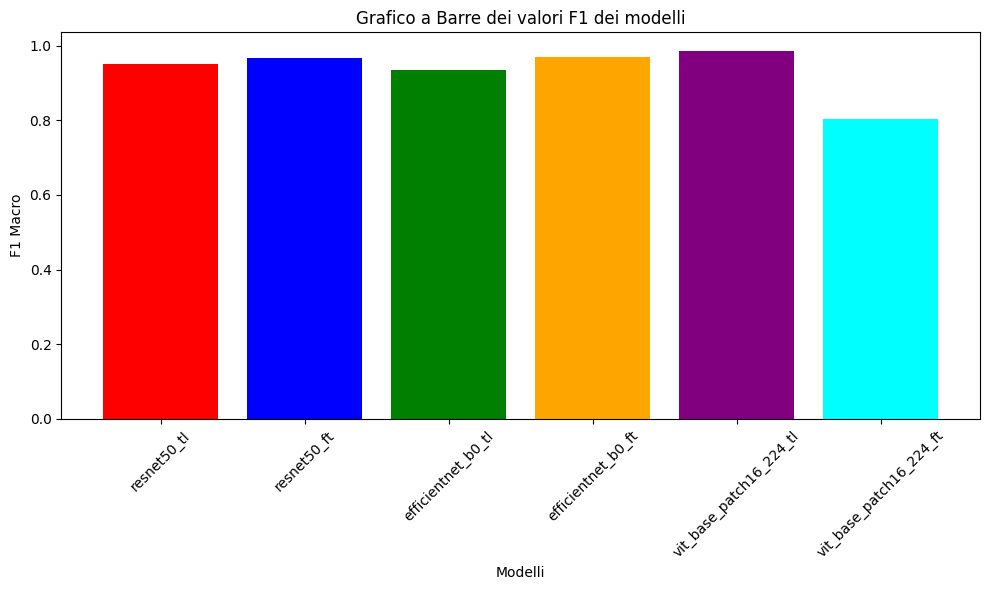

In [18]:
# Estrai le chiavi e i valori dal dizionario
labels = list(best_models_f1.keys())
values = list(best_models_f1.values())

# Definisci una lista di colori (puoi estenderla se hai più modelli)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']

# Crea il grafico a barre con colori diversi per ogni barra
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors[:len(labels)])  # taglia i colori se ce ne sono meno

# Aggiungi titolo e etichette agli assi
plt.title('Grafico a Barre dei valori F1 dei modelli')
plt.xlabel('Modelli')
plt.ylabel('F1 Macro')

# Inclina le etichette dell'asse x
plt.xticks(rotation=45)

# Migliora layout per evitare tagli
plt.tight_layout()

# Visualizza il grafico
plt.show()

#### Il modello migliore è vit_base_patch16_224 addestrato in modalità transfer learning

#### Proviamo ad addestrare questo modello facendo data augmentation del train set, per vedere se le performance migliorano ulteriormente

In [19]:
augmented_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Lieve aumento per poi fare crop
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),  # opzionale, se ha senso nel tuo dataset
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    transforms.Normalize(mean, std)
])

image_datasets['train_aug'] = datasets.ImageFolder("train", transform=augmented_transforms)

dataloaders['train_aug'] = DataLoader(
    image_datasets['train_aug'],
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers
)

In [20]:
## da scrivere per bene il retrain, forse basta solo rilanciarel'addestramento senza ricaricare il modello

# Adatta il modello Vision Transformer
aug_model = adapt_model_for_binary_classification('vit_base_patch16_224')

# Addestra solo gli ultimi strati
aug_f1_tl = train_last_layers(aug_model, dataloaders["train_aug"], dataloaders["validation"], 'aug_f1', num_epochs=num_epochs, patience=patience)

Epoch 1/100: 100%|██████████| 40/40 [00:20<00:00,  1.94it/s]

Epoch 1, Loss: 0.1956584039144218


Validation F1 Macro: 0.9639897417945771
new best f1 macro! model saved!
BEST F1: 0.964


Epoch 2/100: 100%|██████████| 40/40 [00:23<00:00,  1.68it/s]

Epoch 2, Loss: 0.10444934605620801


Validation F1 Macro: 0.9640247842779488
new best f1 macro! model saved!
BEST F1: 0.964


Epoch 3/100: 100%|██████████| 40/40 [00:27<00:00,  1.44it/s]

Epoch 3, Loss: 0.09580461904406548


Validation F1 Macro: 0.9694647174113646
new best f1 macro! model saved!
BEST F1: 0.9695


Epoch 4/100: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]

Epoch 4, Loss: 0.09980337040033191


Validation F1 Macro: 0.9611999390893863
BEST F1: 0.9695


Epoch 5/100: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]

Epoch 5, Loss: 0.09090398806147278


Validation F1 Macro: 0.9750439929611262
new best f1 macro! model saved!
BEST F1: 0.975


Epoch 6/100: 100%|██████████| 40/40 [00:27<00:00,  1.48it/s]

Epoch 6, Loss: 0.0824234995059669


Validation F1 Macro: 0.9750439929611262
BEST F1: 0.975


Epoch 7/100: 100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

Epoch 7, Loss: 0.07264027502387763


Validation F1 Macro: 0.9667761956918584
BEST F1: 0.975


Epoch 8/100: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]

Epoch 8, Loss: 0.08029348945710808


Validation F1 Macro: 0.9722856707781331
BEST F1: 0.975


Epoch 9/100: 100%|██████████| 40/40 [00:25<00:00,  1.56it/s]

Epoch 9, Loss: 0.07461727140471339


Validation F1 Macro: 0.9750439929611262
BEST F1: 0.975


Epoch 10/100: 100%|██████████| 40/40 [00:23<00:00,  1.69it/s]

Epoch 10, Loss: 0.06796456158626825


Validation F1 Macro: 0.9667761956918584
BEST F1: 0.975


Epoch 11/100: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]

Epoch 11, Loss: 0.07506694366456941


Validation F1 Macro: 0.9750439929611262
BEST F1: 0.975


Epoch 12/100: 100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

Epoch 12, Loss: 0.07199652526760474


Validation F1 Macro: 0.9778048780487805
new best f1 macro! model saved!
BEST F1: 0.9778


Epoch 13/100: 100%|██████████| 40/40 [00:23<00:00,  1.74it/s]

Epoch 13, Loss: 0.07205252522835508


Validation F1 Macro: 0.9750698212423996
BEST F1: 0.9778


Epoch 14/100: 100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

Epoch 14, Loss: 0.06742918925592675


Validation F1 Macro: 0.9833536585365854
new best f1 macro! model saved!
BEST F1: 0.9834


Epoch 15/100: 100%|██████████| 40/40 [00:22<00:00,  1.75it/s]

Epoch 15, Loss: 0.06638715057633818


Validation F1 Macro: 0.9833536585365854
BEST F1: 0.9834


Epoch 16/100: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

Epoch 16, Loss: 0.06791534406947904


Validation F1 Macro: 0.9778507971279056
BEST F1: 0.9834


Epoch 17/100: 100%|██████████| 40/40 [00:19<00:00,  2.05it/s]

Epoch 17, Loss: 0.07123649348504842


Validation F1 Macro: 0.9695594328505721
BEST F1: 0.9834


Epoch 18/100: 100%|██████████| 40/40 [00:19<00:00,  2.07it/s]

Epoch 18, Loss: 0.06780864397296682


Validation F1 Macro: 0.9750698212423996
BEST F1: 0.9834


Epoch 19/100: 100%|██████████| 40/40 [00:22<00:00,  1.76it/s]

Epoch 19, Loss: 0.06617028109612874


Validation F1 Macro: 0.9750698212423996
BEST F1: 0.9834


Epoch 20/100: 100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

Epoch 20, Loss: 0.06238334072986618


Validation F1 Macro: 0.9695594328505721
BEST F1: 0.9834


Epoch 21/100: 100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

Epoch 21, Loss: 0.056757673015818


Validation F1 Macro: 0.9722856707781331
BEST F1: 0.9834


Epoch 22/100: 100%|██████████| 40/40 [00:20<00:00,  2.00it/s]

Epoch 22, Loss: 0.05891859314870089


Validation F1 Macro: 0.9640575747218108
BEST F1: 0.9834


Epoch 23/100: 100%|██████████| 40/40 [00:19<00:00,  2.00it/s]

Epoch 23, Loss: 0.05748488249373622


Validation F1 Macro: 0.9723134964098819
BEST F1: 0.9834


Epoch 24/100: 100%|██████████| 40/40 [00:20<00:00,  1.98it/s]

Epoch 24, Loss: 0.05880035007139668


Validation F1 Macro: 0.9640575747218108
BEST F1: 0.9834
Early stopping activated.
Training completed.


#### La data augmentation non ha migliorato ulteriormente le performance del modello. Utilizziamo quindi il modello migliore per un test finale sul test set

In [31]:
def evaluate_and_plot_misclassified(model, dataloader, dataset, device):
    model.eval()
    all_preds = []
    all_labels = []
    misclassified_imgs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified_imgs.append((
                        inputs[i].cpu(),
                        labels[i].item(),
                        preds[i].item()
                    ))

    # Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Confusion matrix (numerica)
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix (raw values):")
    print(cm)

    # Confusion matrix grafica
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes,
                yticklabels=dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Visualizzazione degli errori (1 per tipo)
    error_0_to_1 = next((img for img in misclassified_imgs if img[1] == 0 and img[2] == 1), None)
    error_1_to_0 = next((img for img in misclassified_imgs if img[1] == 1 and img[2] == 0), None)

    num_rows = int(error_0_to_1 is not None) + int(error_1_to_0 is not None)
    if num_rows == 0:
        print("Nessun errore di classificazione trovato.")
        return

    fig, axes = plt.subplots(num_rows, 1, figsize=(6, 3 * num_rows))
    if num_rows == 1:
        axes = [axes]

    i = 0
    if error_0_to_1:
        img, true, pred = error_0_to_1
        axes[i].imshow(img.permute(1, 2, 0).clamp(0, 1))
        axes[i].set_title(f"Errore: Vero = {dataset.classes[true]}, Predetto = {dataset.classes[pred]}")
        axes[i].axis('off')
        i += 1

    if error_1_to_0:
        img, true, pred = error_1_to_0
        axes[i].imshow(img.permute(1, 2, 0).clamp(0, 1))
        axes[i].set_title(f"Errore: Vero = {dataset.classes[true]}, Predetto = {dataset.classes[pred]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

#### Stampiano alcuni indici che descrivono le performance del modello sul test set, la matrice di confusione e un'immagine predetta erroneamente per classe


Classification Report:
              precision    recall  f1-score   support

       daisy       0.99      0.94      0.96        77
   dandelion       0.95      0.99      0.97       105

    accuracy                           0.97       182
   macro avg       0.97      0.96      0.97       182
weighted avg       0.97      0.97      0.97       182

Confusion Matrix (raw values):
[[ 72   5]
 [  1 104]]


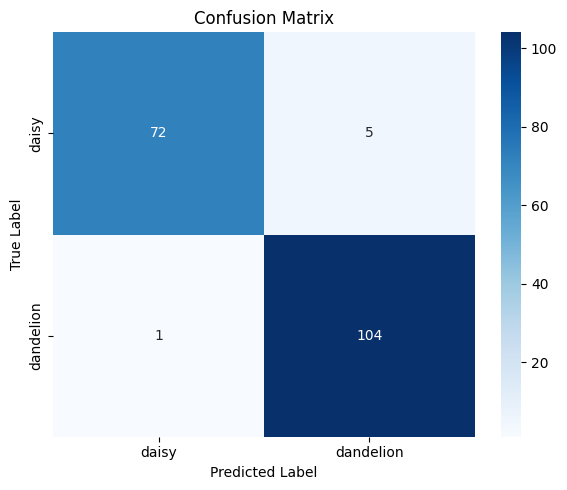

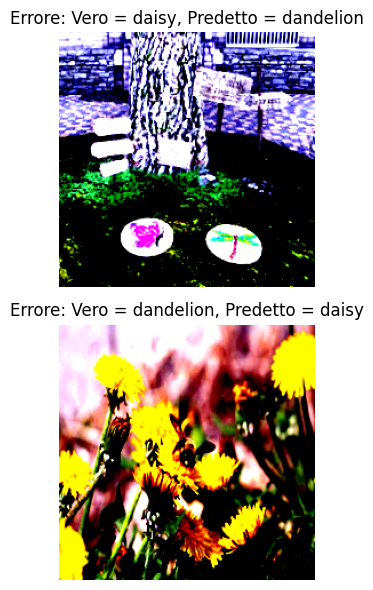

In [32]:
# Inizializza il modello base con 2 output
best_model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=2)
best_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/models/vit_base_patch16_224_tl.pth"))
best_model.to(device)
evaluate_and_plot_misclassified(best_model, dataloaders['test'], image_datasets['test'], device)

#### Il modello riesce a generalizzare anche senza l'applicazione di tecniche di data augmentation

#### Funziona molto bene anche sul test set, riconoscendo correttamente quasi tutte le immagini di test